In [1]:
# In[1]: Import Required Libraries
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import torch.nn as nn
import torch.optim as optim
# In[2]: Load and Split Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# In[2]: Load Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths
data_csv = "ChestX-ray14\Combined_Train_and_Test_Data.csv"
image_directory = 'C:/Users/zafer/OneDrive/Masaüstü/224NIH/dataset/images-224/images-224'

# Load the dataset
data = pd.read_csv(data_csv)

# Filter out labels with fewer than 2 samples
filtered_data = data.groupby('Finding Labels').filter(lambda x: len(x) > 5)

# Verify filtered class distribution
print("Filtered Class Distribution:")
print(filtered_data['Finding Labels'].value_counts())

# Split the filtered dataset into train, validation, and test sets
# Step 1: Train/Test Split
train_data, temp_data = train_test_split(
    filtered_data, 
    test_size=0.3, 
    stratify=filtered_data['Finding Labels'], 
    random_state=42
)

# Step 2: Validation/Test Split
val_data, test_data = train_test_split(
    temp_data, 
    test_size=0.5, 
    stratify=temp_data['Finding Labels'], 
    random_state=42
)

# Display dataset sizes
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Filtered Class Distribution:
Finding Labels
No Finding                                               5128
Infiltration                                             3004
Nodule                                                   2886
Pneumothorax                                             2838
Atelectasis                                              2397
Effusion                                                 2320
Effusion|Infiltration                                    1519
Atelectasis|Effusion                                     1473
Atelectasis|Infiltration                                 1225
Infiltration|Nodule                                      1159
Atelectasis|Effusion|Infiltration                        1106
Effusion|Pneumothorax                                     751
Infiltration|Pneumothorax                                 608
Atelectasis|Pneumothorax                                  538
Effusion|Nodule                                           527
Atelectasis|Nodule        

In [3]:
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

        # Validate the dataset
        valid_samples = []
        for idx in range(len(self.dataframe)):
            row = self.dataframe.iloc[idx]
            image_path = os.path.join(self.image_dir, row['Image Index'])
            if os.path.exists(image_path):
                valid_samples.append(row)
            else:
                print(f"Missing image: {image_path}")
        self.dataframe = pd.DataFrame(valid_samples)

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_dir, row['Image Index'])
        try:
            image = Image.open(image_path).convert("L")  # Convert to grayscale
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return self.__getitem__((idx + 1) % len(self.dataframe))  # Skip problematic image

        label = row['Finding Labels']
        findings = ["Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "No Finding"]
        label_vector = [1 if finding in label else 0 for finding in findings]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label_vector, dtype=torch.float)


In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Transforms for train and test
train_transform = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Datasets
train_dataset = ChestXRayDataset(train_data, image_directory, transform=train_transform)
val_dataset = ChestXRayDataset(val_data, image_directory, transform=test_transform)
test_dataset = ChestXRayDataset(test_data, image_directory, transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
import torch
import numpy as np

# List of findings
findings = ["Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "No Finding"]

# Initialize counts for each finding
class_counts = {finding: 0 for finding in findings}

# Count occurrences of each finding in the training dataset
for labels in train_data['Finding Labels']:
    for finding in findings:
        if finding in labels:
            class_counts[finding] += 1

# Calculate weights inversely proportional to class frequencies
total_samples = len(train_data)
class_weights = [total_samples / class_counts[finding] for finding in findings]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensor for PyTorch
class_weights_tensor = torch.tensor(class_weights).to(device)

# Define the weighted BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# Print class weights for verification
print("Class Weights:", class_weights)


Class Weights: [3.0178314639056656, 3.6631174725082913, 3.317420170723996, 4.774971558589306, 4.8388286834217205, 5.847311228754528]


In [15]:
print(train_data.shape)  # Should print (num_samples, 6)


(20986, 13)


In [18]:
from torchvision import models
import torch.nn as nn
import torch

# Load pretrained ResNet50 and adjust for grayscale input
model = models.resnet50(pretrained=True)

# Modify the first convolutional layer for grayscale input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Customize classifier for 6-class multi-label output
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 6)  # No Sigmoid here
)

# Assuming train_labels is a torch Tensor of shape [num_samples, num_classes]


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

# Fine-tune the last few layers
for param in model.layer4.parameters():  # Unfreeze the last ResNet block (layer4)
    param.requires_grad = True

# Freeze earlier layers
for param in list(model.parameters())[:-len(list(model.layer4.parameters()))]:
    param.requires_grad = False

# Move model to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)  # Print the model architecture for verification


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.grad}")


layer4.0.bn2.weight: None
layer4.0.bn2.bias: None
layer4.0.conv3.weight: None
layer4.0.bn3.weight: None
layer4.0.bn3.bias: None
layer4.0.downsample.0.weight: None
layer4.0.downsample.1.weight: None
layer4.0.downsample.1.bias: None
layer4.1.conv1.weight: None
layer4.1.bn1.weight: None
layer4.1.bn1.bias: None
layer4.1.conv2.weight: None
layer4.1.bn2.weight: None
layer4.1.bn2.bias: None
layer4.1.conv3.weight: None
layer4.1.bn3.weight: None
layer4.1.bn3.bias: None
layer4.2.conv1.weight: None
layer4.2.bn1.weight: None
layer4.2.bn1.bias: None
layer4.2.conv2.weight: None
layer4.2.bn2.weight: None
layer4.2.bn2.bias: None
layer4.2.conv3.weight: None
layer4.2.bn3.weight: None
layer4.2.bn3.bias: None
fc.0.weight: None
fc.0.bias: None
fc.3.weight: None
fc.3.bias: None


In [20]:
print(f"Class distribution: {torch.sum(labels, dim=0)}")


Class distribution: tensor([ 8., 10., 11., 10., 11.,  4.], device='cuda:0')


In [21]:
from tqdm import tqdm  # For progress bar
import numpy as np
import torch

# Define EarlyStopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pth.tar'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path to save the model checkpoint.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, optimizer, epoch):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, self.path)
        self.val_loss_min = val_loss


# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=5, verbose=True, path='best_model.pth.tar')

# List to store validation losses
val_losses = []

# Training Loop with Early Stopping and Progress Bar
epochs = 50  # Set a higher number; early stopping will terminate earlier if needed
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Training phase with progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=True)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({"Training Loss": running_loss / (len(progress_bar) + 1)})

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    progress_bar.set_postfix({"Training Loss": running_loss / len(train_loader), "Validation Loss": val_loss})
    print(f"Epoch {epoch + 1}/{epochs} Complete")
    val_losses.append(val_loss)

    # Early Stopping Check
    early_stopping(val_loss, model, optimizer, epoch)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Load the best model checkpoint
checkpoint = torch.load('best_model.pth.tar')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Resuming from epoch {checkpoint['epoch']}")

# Print or plot validation losses after training
print("Validation Losses:", val_losses)


Epoch 1/50: 100%|██████████| 656/656 [01:40<00:00,  6.50it/s, Training Loss=0.512] 


Epoch 1/50, Loss: 0.5127
Epoch 1/50 Complete
Validation loss decreased (inf --> 0.498467). Saving model...


Epoch 2/50: 100%|██████████| 656/656 [01:36<00:00,  6.83it/s, Training Loss=0.493] 


Epoch 2/50, Loss: 0.4942
Epoch 2/50 Complete
Validation loss decreased (0.498467 --> 0.486564). Saving model...


Epoch 3/50: 100%|██████████| 656/656 [01:36<00:00,  6.82it/s, Training Loss=0.486] 


Epoch 3/50, Loss: 0.4863
Epoch 3/50 Complete
Validation loss decreased (0.486564 --> 0.481715). Saving model...


Epoch 4/50: 100%|██████████| 656/656 [01:35<00:00,  6.85it/s, Training Loss=0.479] 


Epoch 4/50, Loss: 0.4801
Epoch 4/50 Complete
Validation loss decreased (0.481715 --> 0.479833). Saving model...


Epoch 5/50: 100%|██████████| 656/656 [01:36<00:00,  6.79it/s, Training Loss=0.473] 


Epoch 5/50, Loss: 0.4739
Epoch 5/50 Complete
Validation loss decreased (0.479833 --> 0.479547). Saving model...


Epoch 6/50: 100%|██████████| 656/656 [01:36<00:00,  6.79it/s, Training Loss=0.468] 


Epoch 6/50, Loss: 0.4691
Epoch 6/50 Complete
Validation loss decreased (0.479547 --> 0.475938). Saving model...


Epoch 7/50: 100%|██████████| 656/656 [01:39<00:00,  6.61it/s, Training Loss=0.463] 


Epoch 7/50, Loss: 0.4641
Epoch 7/50 Complete
Validation loss decreased (0.475938 --> 0.471608). Saving model...


Epoch 8/50: 100%|██████████| 656/656 [01:37<00:00,  6.73it/s, Training Loss=0.457] 


Epoch 8/50, Loss: 0.4582
Epoch 8/50 Complete
Validation loss decreased (0.471608 --> 0.469891). Saving model...


Epoch 9/50: 100%|██████████| 656/656 [01:37<00:00,  6.73it/s, Training Loss=0.452] 


Epoch 9/50, Loss: 0.4523
Epoch 9/50 Complete
Validation loss decreased (0.469891 --> 0.465676). Saving model...


Epoch 10/50: 100%|██████████| 656/656 [01:36<00:00,  6.77it/s, Training Loss=0.446] 


Epoch 10/50, Loss: 0.4465
Epoch 10/50 Complete
Validation loss decreased (0.465676 --> 0.465199). Saving model...


Epoch 11/50: 100%|██████████| 656/656 [01:35<00:00,  6.87it/s, Training Loss=0.441] 


Epoch 11/50, Loss: 0.4414
Epoch 11/50 Complete
EarlyStopping counter: 1 out of 5


Epoch 12/50: 100%|██████████| 656/656 [01:35<00:00,  6.86it/s, Training Loss=0.434] 


Epoch 12/50, Loss: 0.4347
Epoch 12/50 Complete
Validation loss decreased (0.465199 --> 0.461301). Saving model...


Epoch 13/50: 100%|██████████| 656/656 [01:38<00:00,  6.65it/s, Training Loss=0.429] 


Epoch 13/50, Loss: 0.4294
Epoch 13/50 Complete
EarlyStopping counter: 1 out of 5


Epoch 14/50: 100%|██████████| 656/656 [01:36<00:00,  6.81it/s, Training Loss=0.422] 


Epoch 14/50, Loss: 0.4227
Epoch 14/50 Complete
Validation loss decreased (0.461301 --> 0.459313). Saving model...


Epoch 15/50: 100%|██████████| 656/656 [01:35<00:00,  6.88it/s, Training Loss=0.417] 


Epoch 15/50, Loss: 0.4173
Epoch 15/50 Complete
EarlyStopping counter: 1 out of 5


Epoch 16/50: 100%|██████████| 656/656 [01:36<00:00,  6.81it/s, Training Loss=0.409] 


Epoch 16/50, Loss: 0.4093
Epoch 16/50 Complete
EarlyStopping counter: 2 out of 5


Epoch 17/50: 100%|██████████| 656/656 [01:35<00:00,  6.87it/s, Training Loss=0.404] 


Epoch 17/50, Loss: 0.4048
Epoch 17/50 Complete
EarlyStopping counter: 3 out of 5


Epoch 18/50: 100%|██████████| 656/656 [01:35<00:00,  6.85it/s, Training Loss=0.397] 


Epoch 18/50, Loss: 0.3971
Epoch 18/50 Complete
EarlyStopping counter: 4 out of 5


Epoch 19/50: 100%|██████████| 656/656 [01:36<00:00,  6.78it/s, Training Loss=0.39]  


Epoch 19/50, Loss: 0.3907
Epoch 19/50 Complete
EarlyStopping counter: 5 out of 5
Early stopping triggered.
Resuming from epoch 13
Validation Losses: [0.49846695691135756, 0.48656376984947963, 0.48171509897455256, 0.4798325169171002, 0.4795469470480655, 0.47593835820543007, 0.47160759927533197, 0.4698908153577899, 0.465675765529592, 0.4651989733919184, 0.4680805301412623, 0.4613011248990999, 0.4685375071163719, 0.45931276467675014, 0.46146004652300626, 0.4634238521680764, 0.46323480885079565, 0.4665476958802406, 0.4636821945508321]


C:\Users\zafer\AppData\Local\Temp\ipykernel_33600\968969881.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth.tar')


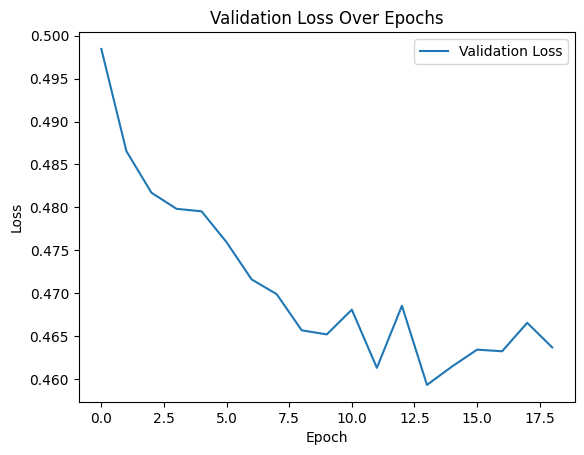

In [22]:
import matplotlib.pyplot as plt

plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()


In [29]:
import torch

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in val_loader:  # Replace val_loader with your validation DataLoader
        images = images.to(device)
        outputs = model(images)  # Raw logits
        probabilities = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
        y_pred.extend(probabilities)
        y_true.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)


In [30]:
from sklearn.metrics import roc_auc_score

class_names = ["Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "No Finding"]

# Assuming y_true (ground truth) and y_pred (predictions) are numpy arrays
# Shape: [num_samples, num_classes]
aurocs = {}
for i, class_name in enumerate(class_names):  # Replace class_names with your actual class names
    try:
        auroc = roc_auc_score(y_true[:, i], y_pred[:, i])
        aurocs[class_name] = auroc
    except ValueError:
        # Handle case where a class has only one label value (all 0s or 1s)
        aurocs[class_name] = None
        print(f"AUROC for {class_name} could not be calculated due to single-class labels.")

# Print AUROC for each class
for class_name, auroc in aurocs.items():
    if auroc is not None:
        print(f"AUROC for {class_name}: {auroc:.4f}")
    else:
        print(f"AUROC for {class_name}: Not Applicable")


AUROC for Infiltration: 0.6985
AUROC for Atelectasis: 0.7515
AUROC for Effusion: 0.8491
AUROC for Nodule: 0.7195
AUROC for Pneumothorax: 0.8339
AUROC for No Finding: 0.7894


In [31]:
valid_aurocs = [auroc for auroc in aurocs.values() if auroc is not None]
average_auroc = sum(valid_aurocs) / len(valid_aurocs) if valid_aurocs else 0
print(f"Average AUROC: {average_auroc:.4f}")


Average AUROC: 0.7736


In [ ]:
# In[9]: Save Model
torch.save(model.state_dict(), "chest_xray_model.pth.tar")
print("Model saved as 'chest_xray_model.pth.tar'")

Model saved as 'chest_xray_model.pth.tar'
